<a href="https://colab.research.google.com/github/tsmanral/Author-Prediction-Using-Deep-Learning-Models/blob/master/POS_Model_for_FFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Flatten, GlobalAveragePooling1D
from keras.layers import Embedding, TimeDistributed
import keras.utils
from keras.callbacks import ModelCheckpoint  


In [0]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data_pos')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1OIo2AFE5433kfj9QGpGJVYERoWcmXVzB' in parents"}).GetList()

data = []
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  with open(fname, 'r', encoding = "ISO-8859-1") as file:
    data.append([f['title'].split('-')[0], file.read()])

title: George Gissing - 2.txt, id: 1lCMmjhdF4MlD8mWVVhMgdUDv7Hki3_-d
downloading to /content/data_pos/George Gissing - 2.txt
title: Humphrey Ward - 13.txt, id: 1yP2cZU3-djw5epRNhUyRf3Cprc-adBtq
downloading to /content/data_pos/Humphrey Ward - 13.txt
title: George Gissing - 15.txt, id: 16Qap744WSUYEpbPIYRfIWnxAkB5rnXiL
downloading to /content/data_pos/George Gissing - 15.txt
title: Arthur Conan Doyle - 11.txt, id: 1HB_DcPLPafswhFbgjRYImH8GfBvghplJ
downloading to /content/data_pos/Arthur Conan Doyle - 11.txt
title: Humphrey Ward - 10.txt, id: 1Tiqv8_lApsZPbgANKnGH_NmXotwmNx4G
downloading to /content/data_pos/Humphrey Ward - 10.txt
title: Arthur Conan Doyle - 10.txt, id: 1nRXK4FBhXvehImie22HvK4qG5FISiHFu
downloading to /content/data_pos/Arthur Conan Doyle - 10.txt
title: Arthur Conan Doyle - 7.txt, id: 1nz4_r-CvQZwKg91cnAvsHQE7UvA4eWoj
downloading to /content/data_pos/Arthur Conan Doyle - 7.txt
title: Henry Rider Haggard - 7.txt, id: 1vfyVPEJUqVHhyQd-4rJ4qLCfxoAY5kDO
downloading to /conte

title: Gilbert Parker - 13.txt, id: 1O-O3f6NFXYFZYy9f5HkIVKIEqNH9sgy_
downloading to /content/data_pos/Gilbert Parker - 13.txt
title: Arthur Conan Doyle - 16.txt, id: 1WXzRRGG2pt9QC3a1oan3Wg-Hfe3QJBLi
downloading to /content/data_pos/Arthur Conan Doyle - 16.txt
title: Henry Rider Haggard - 12.txt, id: 1oDjEYDQjP7KdxO2VpzU08m5kJXdPOTK4
downloading to /content/data_pos/Henry Rider Haggard - 12.txt
title: Henry Rider Haggard - 25.txt, id: 1BrlRls7K1mCOdefL5Ih0Cr3jFpfxGqbv
downloading to /content/data_pos/Henry Rider Haggard - 25.txt
title: Arthur Conan Doyle - 12.txt, id: 1PSFBrdrggGe1b_1Z2O5WdnlHkdFSFOo_
downloading to /content/data_pos/Arthur Conan Doyle - 12.txt
title: Arthur Conan Doyle - 4.txt, id: 1p-XRhYDQCdccoYflkHuAdXkZVOwjpfdm
downloading to /content/data_pos/Arthur Conan Doyle - 4.txt
title: Humphrey Ward - 8.txt, id: 1E3UCDg2V70_N1nxpFSsrAiyBVziTMRdl
downloading to /content/data_pos/Humphrey Ward - 8.txt
title: Gilbert Parker - 7.txt, id: 1I2AgUyOdTnZ76rTHjsQRUmANa5P_5pqH
down

title: Gilbert Parker - 5.txt, id: 1atkDIkWgZN0xOYrLc0CAcmtS5x1kJqD0
downloading to /content/data_pos/Gilbert Parker - 5.txt
title: Henry Rider Haggard - 9.txt, id: 1IDmhDWbLnsoPrRkQwdrejXAm3WL4Z7m8
downloading to /content/data_pos/Henry Rider Haggard - 9.txt
title: Humphrey Ward - 14.txt, id: 1CzoKzHf8dCmvKo_x5Bd7cDxpUaINqowR
downloading to /content/data_pos/Humphrey Ward - 14.txt
title: Gilbert Parker - 12.txt, id: 1n_S6h-ax02aDj8sGXNLGqrHRtHhCR8eh
downloading to /content/data_pos/Gilbert Parker - 12.txt
title: Arthur Conan Doyle - 5.txt, id: 1UVH3T5AUm6Xyd7W4q-H07H1gOGkD17-g
downloading to /content/data_pos/Arthur Conan Doyle - 5.txt
title: Gilbert Parker - 6.txt, id: 1smgTQyEwOyvyB1bxp2YIF03urzWAkr3A
downloading to /content/data_pos/Gilbert Parker - 6.txt
title: Humphrey Ward - 15.txt, id: 1mgS1p_sVn70GjneAqQryC43fUphPZ1gC
downloading to /content/data_pos/Humphrey Ward - 15.txt
title: Henry Rider Haggard - 19.txt, id: 17kGjYBSqYp4RwYY8HIL3-pphflfxxKbw
downloading to /content/data_p

In [0]:
X = []
for _,c in data:
    X.append(c.lower())
    
Y = []
for i,_ in data:
    Y.append(i.lower())

X1 = []
Y_data1 = []

for text in X:
  c = text.strip().split()
  X1.append(c)

print(len(X))
X_data1 = []
count = 0
for i in X1:
  m=0
  n=1000
  times = len(i)//1000
  for j in range(times):
    X_data1.append(i[m:n])
    m = m + 1000
    n = n + 1000
    Y_data1.append(Y[count]) 
  X_data1.append(i[m:len(i)+1])
  Y_data1.append(Y[count])
  count = count + 1 



98


In [0]:
temp_list = []
for i in range(len(X_data1)):
  temp_list.append([X_data1[i], Y_data1[i]])
print(len(temp_list))
print(temp_list[0][1])

import random

random.shuffle(temp_list)
print(len(temp_list))
print(temp_list[0][1])

X_data = []
Y_data = []
for i in range(len(temp_list)):
  X_data.append(temp_list[i][0])
  Y_data.append(temp_list[i][1])
print(len(X_data), len(Y_data))
print(X_data[0], Y_data[0])

11163
george gissing 
11163
george gissing 
11163 11163
['nn', 'in', 'dt', 'rbs', 'jj', 'nn', 'rb', 'vbg', 'to', 'nn', 'cc', 'rb', 'rb', 'to', 'nn', 'dt', 'nn', 'in', 'dt', 'nn', 'dt', 'nn', 'nn', 'prp', 'vbd', 'prp', 'jj', 'in', 'dt', 'jj', 'nn', 'in', 'dt', 'jj', 'nn', 'to', 'vb', 'dt', 'nn', 'in', 'nn', 'cc', 'in', 'dt', 'nn', 'prp', 'vbd', 'to', 'dt', 'nn', 'in', 'dt', 'nn', 'jj', 'nn', 'rb', 'cc', 'rb', 'nn', 'vbg', 'in', 'nn', 'prp', 'vbd', 'rb', 'jj', 'cc', 'prp', 'vbd', 'rb', 'vb', 'jj', 'nn', 'in', 'prp$', 'nn', 'nn', 'nn', 'in', 'dt', 'jjr', 'nn', 'in', 'dt', 'nn', 'vbd', 'prp', 'vbg', 'nn', 'dt', 'cd', 'vbd', 'vbg', 'in', 'dt', 'nn', 'rp', 'in', 'dt', 'nn', 'prp', 'vbd', 'in', 'prp', 'vbd', 'jj', 'in', 'dt', 'nn', 'prp', 'md', 'nns', 'vb', 'in', 'dt', 'nn', 'prp', 'cc', 'vb', 'dt', 'nn', 'wrb', 'dt', 'nn', 'nns', 'vbd', 'vbn', 'cc', 'dt', 'nn', 'vbd', 'nnp', 'nnp', 'vbd', 'dt', 'jj', 'nn', 'in', 'in', 'dt', 'jj', 'cc', 'rb', 'jj', 'nn', 'in', 'dt', 'jj', 'nn', 'in', 'prp$', 

In [0]:
print(len(X_data))

11163


In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Converting Output values to One Hot Vector
print("Converting to One hot vector(training set)...")
Y_data = np.array(Y_data)

label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(Y_data)
print(train_integer_encoded[:500])

Converting to One hot vector(training set)...
[1 0 3 0 1 0 4 4 3 0 4 1 0 3 4 2 3 0 4 3 1 0 2 2 3 4 1 2 1 4 3 4 1 1 3 1 3
 1 0 0 4 3 0 4 1 3 4 4 4 4 4 3 1 2 3 4 1 3 3 1 4 4 2 4 2 4 2 1 3 1 4 2 3 4
 4 4 0 2 3 1 1 1 1 4 2 3 2 2 2 3 4 0 1 0 1 3 4 1 0 2 4 1 4 2 1 0 1 3 4 1 1
 2 1 2 4 0 4 1 0 0 1 1 1 1 3 4 4 1 2 2 4 3 2 3 4 3 3 1 3 1 3 0 2 1 2 4 1 1
 1 2 0 2 3 4 1 2 4 1 4 4 0 3 1 3 4 1 3 3 2 1 2 1 3 1 1 1 0 1 1 4 2 3 1 3 1
 2 1 2 0 0 3 1 1 1 3 4 1 1 4 3 4 4 4 1 2 1 0 0 1 1 4 2 0 4 1 2 2 4 1 2 4 4
 1 4 4 2 2 1 1 0 4 3 1 1 1 2 4 1 0 0 0 0 3 4 3 2 4 3 1 0 3 2 4 2 4 1 0 3 0
 0 1 0 2 3 3 0 0 2 1 1 3 1 4 1 4 1 3 2 1 3 1 4 3 2 1 1 3 4 4 1 4 0 1 4 3 4
 4 3 1 1 3 4 1 3 2 1 0 0 1 2 3 2 2 0 4 0 4 1 2 4 3 4 2 4 0 0 1 2 1 3 1 4 1
 0 3 3 0 3 1 1 1 3 1 3 4 4 2 1 3 1 4 0 4 0 3 3 2 3 4 3 0 3 2 2 3 2 1 3 3 3
 4 1 1 2 3 3 3 4 1 4 2 1 0 1 1 0 1 1 0 0 2 1 0 3 4 1 2 4 1 2 1 0 0 1 4 4 3
 1 1 2 3 1 1 4 3 1 0 4 3 0 2 4 3 1 4 1 1 1 4 1 4 3 4 3 3 2 4 0 0 3 3 4 3 3
 0 1 3 3 0 3 2 1 3 3 3 0 4 1 3 1 0 3 4 1 2 1 4 1 4 4 2

In [0]:
train_onehot_encoded = keras.utils.to_categorical(train_integer_encoded)
print(train_onehot_encoded[2824,:])

[1. 0. 0. 0. 0.]


In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
print(vocab_size)

35


In [0]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_data)
print(encoded_docs[0])

[1, 2, 3, 32, 4, 1, 8, 17, 15, 1, 7, 8, 8, 15, 1, 3, 1, 2, 3, 1, 3, 1, 1, 6, 5, 6, 4, 2, 3, 4, 1, 2, 3, 4, 1, 15, 13, 3, 1, 2, 1, 7, 2, 3, 1, 6, 5, 15, 3, 1, 2, 3, 1, 4, 1, 8, 7, 8, 1, 17, 2, 1, 6, 5, 8, 4, 7, 6, 5, 8, 13, 4, 1, 2, 12, 1, 1, 1, 2, 3, 25, 1, 2, 3, 1, 5, 6, 17, 1, 3, 21, 5, 17, 2, 3, 1, 24, 2, 3, 1, 6, 5, 2, 6, 5, 4, 2, 3, 1, 6, 18, 11, 13, 2, 3, 1, 6, 7, 13, 3, 1, 23, 3, 1, 11, 5, 14, 7, 3, 1, 5, 9, 9, 5, 3, 4, 1, 2, 2, 3, 4, 7, 8, 4, 1, 2, 3, 4, 1, 2, 12, 10, 10, 10, 10, 9, 9, 6, 10, 10, 15, 13, 8, 23, 16, 1, 14, 17, 1, 7, 23, 19, 1, 3, 1, 5, 3, 1, 2, 3, 1, 1, 7, 5, 15, 13, 2, 3, 10, 10, 10, 2, 3, 1, 6, 5, 2, 3, 5, 2, 3, 19, 3, 4, 1, 6, 5, 14, 9, 7, 5, 15, 13, 12, 1, 3, 11, 6, 5, 8, 14, 2, 3, 4, 1, 2, 11, 2, 8, 17, 14, 28, 8, 2, 3, 1, 8, 14, 1, 3, 1, 7, 3, 1, 2, 1, 18, 8, 8, 16, 14, 2, 9, 9, 3, 8, 4, 1, 2, 1, 7, 8, 4, 2, 17, 3, 1, 2, 1, 2, 22, 6, 8, 5, 15, 13, 2, 12, 11, 7, 15, 13, 4, 1, 7, 3, 1, 6, 5, 15, 13, 15, 3, 4, 1, 1, 3, 1, 14, 8, 4, 8, 2, 29, 3, 1, 26, 5, 14, 

In [0]:
# pad documents to a max length of 10000 words
max_length = 1000
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[ 1  2  3 ...  1  5  6]
 [ 4  1 22 ... 17 24  4]
 [ 4  1 14 ...  6 13 10]
 ...
 [12  1  7 ...  4  1  2]
 [ 4  1  4 ...  5 21  4]
 [20 16  2 ...  4  2  3]]


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1ogZLyJ5GTI8a0o8HPac8zTtm96SzCv-k' in parents"}).GetList()
print(file_list[0]['title'], file_list[0]['id'] )
fname = os.path.join(local_download_path, file_list[0]['title'])
f_ = drive.CreateFile({'id': file_list[0]['id']})
f_.GetContentFile(fname)


# load the whole embedding into memory
embeddings_index = dict()
f = open(fname)
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

glove.6B.100d.txt 17BmrNJa4oJDNg3KZ6u2Ww0ETQYklOJJ7
Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(35, 100)


In [0]:
print(padded_docs.shape)
doc_train = np.array(padded_docs[0:8000,:])
print(doc_train.shape)
doc_test = np.array(padded_docs[8000:,:])
print(doc_test.shape)

onehot_train = np.array(train_onehot_encoded[0:8000,:])
print(onehot_train.shape)
onehot_test = np.array(train_onehot_encoded[8000:,:])
print(onehot_test.shape)

(11163, 1000)
(8000, 1000)
(3163, 1000)
(8000, 5)
(3163, 5)


In [0]:


# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1000, trainable=False)
model.add(e)
model.add(GlobalAveragePooling1D())


#model.add(Dropout(0.5))

model.add(Dense(500, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.8))
model.add(Dense(1000, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.7))


model.add(Dense(5, activation='softmax'))


In [0]:
# compile the model
#from keras.optimizers import SGD
num_of_epochs = 500
batchsize = 512
#learning_rate = 0.01

#momentum = 0.8
#sgd = SGD(lr=learning_rate, nesterov=False) #  momentum=momentum,
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         3500      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               50500     
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 5005      
Total para

In [0]:
checkpointer = ModelCheckpoint(filepath='/content/weights.best.FFN_pos.hdf5', 
                               verbose=1, save_best_only=True)

In [0]:
# fit the model
history = model.fit(doc_train, onehot_train, epochs=num_of_epochs, verbose=1, batch_size=batchsize, validation_split=0.2, callbacks=[checkpointer])

Train on 6400 samples, validate on 1600 samples
Epoch 1/500
6400/6400 [==============================] - 0s 73us/step - loss: 1.5615 - categorical_accuracy: 0.2994 - val_loss: 1.4805 - val_categorical_accuracy: 0.3256

Epoch 00001: val_loss improved from inf to 1.48046, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 2/500
6400/6400 [==============================] - 0s 44us/step - loss: 1.4547 - categorical_accuracy: 0.3852 - val_loss: 1.3698 - val_categorical_accuracy: 0.4213

Epoch 00002: val_loss improved from 1.48046 to 1.36983, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 3/500
6400/6400 [==============================] - 0s 37us/step - loss: 1.3535 - categorical_accuracy: 0.4442 - val_loss: 1.3096 - val_categorical_accuracy: 0.3819

Epoch 00003: val_loss improved from 1.36983 to 1.30960, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 4/500
6400/6400 [==============================] - 0s 37us/step - loss: 1.2891 - categorical_accuracy: 0.4681 - val_

6400/6400 [==============================] - 0s 34us/step - loss: 0.9449 - categorical_accuracy: 0.6211 - val_loss: 0.9348 - val_categorical_accuracy: 0.6381

Epoch 00013: val_loss did not improve
Epoch 14/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.8909 - categorical_accuracy: 0.6517 - val_loss: 0.8051 - val_categorical_accuracy: 0.6606

Epoch 00014: val_loss improved from 0.83122 to 0.80514, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 15/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.8615 - categorical_accuracy: 0.6752 - val_loss: 0.7488 - val_categorical_accuracy: 0.7106

Epoch 00015: val_loss improved from 0.80514 to 0.74884, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 16/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.8623 - categorical_accuracy: 0.6683 - val_loss: 0.7478 - val_categorical_accuracy: 0.7106

Epoch 00016: val_loss improved from 0.74884 to 0.74779, saving model to /

6400/6400 [==============================] - 0s 35us/step - loss: 0.6564 - categorical_accuracy: 0.7459 - val_loss: 0.5423 - val_categorical_accuracy: 0.8037

Epoch 00027: val_loss did not improve
Epoch 28/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.6329 - categorical_accuracy: 0.7606 - val_loss: 0.5067 - val_categorical_accuracy: 0.8106

Epoch 00028: val_loss did not improve
Epoch 29/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.6205 - categorical_accuracy: 0.7677 - val_loss: 0.4496 - val_categorical_accuracy: 0.8581

Epoch 00029: val_loss improved from 0.45353 to 0.44955, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 30/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.6092 - categorical_accuracy: 0.7670 - val_loss: 0.4551 - val_categorical_accuracy: 0.8644

Epoch 00030: val_loss did not improve
Epoch 31/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.5775 - categorical_accu

6400/6400 [==============================] - 0s 36us/step - loss: 0.4912 - categorical_accuracy: 0.8172 - val_loss: 0.3590 - val_categorical_accuracy: 0.8600

Epoch 00040: val_loss did not improve
Epoch 41/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.4841 - categorical_accuracy: 0.8170 - val_loss: 0.3125 - val_categorical_accuracy: 0.9062

Epoch 00041: val_loss did not improve
Epoch 42/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.4970 - categorical_accuracy: 0.8202 - val_loss: 0.3867 - val_categorical_accuracy: 0.8538

Epoch 00042: val_loss did not improve
Epoch 43/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.4916 - categorical_accuracy: 0.8148 - val_loss: 0.4146 - val_categorical_accuracy: 0.8531

Epoch 00043: val_loss did not improve
Epoch 44/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.4517 - categorical_accuracy: 0.8320 - val_loss: 0.2733 - val_categorical_accuracy: 0.9175

E

6400/6400 [==============================] - 0s 34us/step - loss: 0.3784 - categorical_accuracy: 0.8617 - val_loss: 0.2024 - val_categorical_accuracy: 0.9419

Epoch 00054: val_loss improved from 0.20297 to 0.20241, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 55/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.3880 - categorical_accuracy: 0.8605 - val_loss: 0.3790 - val_categorical_accuracy: 0.8469

Epoch 00055: val_loss did not improve
Epoch 56/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.3808 - categorical_accuracy: 0.8619 - val_loss: 0.2206 - val_categorical_accuracy: 0.9213

Epoch 00056: val_loss did not improve
Epoch 57/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.4104 - categorical_accuracy: 0.8439 - val_loss: 0.1964 - val_categorical_accuracy: 0.9325

Epoch 00057: val_loss improved from 0.20241 to 0.19635, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 58/500
6400/6400 [===========

6400/6400 [==============================] - 0s 34us/step - loss: 0.3268 - categorical_accuracy: 0.8750 - val_loss: 0.1611 - val_categorical_accuracy: 0.9613

Epoch 00068: val_loss did not improve
Epoch 69/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.3571 - categorical_accuracy: 0.8658 - val_loss: 0.1296 - val_categorical_accuracy: 0.9681

Epoch 00069: val_loss improved from 0.14615 to 0.12959, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 70/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.3018 - categorical_accuracy: 0.8944 - val_loss: 0.1394 - val_categorical_accuracy: 0.9494

Epoch 00070: val_loss did not improve
Epoch 71/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.3157 - categorical_accuracy: 0.8783 - val_loss: 0.1530 - val_categorical_accuracy: 0.9537

Epoch 00071: val_loss did not improve
Epoch 72/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.2666 - categorical_accu

6400/6400 [==============================] - 0s 36us/step - loss: 0.2983 - categorical_accuracy: 0.8930 - val_loss: 0.0931 - val_categorical_accuracy: 0.9712

Epoch 00082: val_loss improved from 0.12959 to 0.09313, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 83/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.2904 - categorical_accuracy: 0.8914 - val_loss: 0.1008 - val_categorical_accuracy: 0.9675

Epoch 00083: val_loss did not improve
Epoch 84/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.2434 - categorical_accuracy: 0.9122 - val_loss: 0.1192 - val_categorical_accuracy: 0.9706

Epoch 00084: val_loss did not improve
Epoch 85/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.2951 - categorical_accuracy: 0.8900 - val_loss: 0.1830 - val_categorical_accuracy: 0.9263

Epoch 00085: val_loss did not improve
Epoch 86/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.2182 - categorical_accu

6400/6400 [==============================] - 0s 33us/step - loss: 0.2608 - categorical_accuracy: 0.9044 - val_loss: 0.0698 - val_categorical_accuracy: 0.9775

Epoch 00096: val_loss improved from 0.07889 to 0.06979, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 97/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.2043 - categorical_accuracy: 0.9272 - val_loss: 0.1239 - val_categorical_accuracy: 0.9650

Epoch 00097: val_loss did not improve
Epoch 98/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.2435 - categorical_accuracy: 0.9105 - val_loss: 0.0808 - val_categorical_accuracy: 0.9725

Epoch 00098: val_loss did not improve
Epoch 99/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.2344 - categorical_accuracy: 0.9148 - val_loss: 0.0939 - val_categorical_accuracy: 0.9644

Epoch 00099: val_loss did not improve
Epoch 100/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.2286 - categorical_acc

6400/6400 [==============================] - 0s 35us/step - loss: 0.2180 - categorical_accuracy: 0.9203 - val_loss: 0.1477 - val_categorical_accuracy: 0.9419

Epoch 00110: val_loss did not improve
Epoch 111/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.1953 - categorical_accuracy: 0.9295 - val_loss: 0.0968 - val_categorical_accuracy: 0.9744

Epoch 00111: val_loss did not improve
Epoch 112/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1974 - categorical_accuracy: 0.9281 - val_loss: 0.0572 - val_categorical_accuracy: 0.9831

Epoch 00112: val_loss did not improve
Epoch 113/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.2291 - categorical_accuracy: 0.9133 - val_loss: 0.0684 - val_categorical_accuracy: 0.9794

Epoch 00113: val_loss did not improve
Epoch 114/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.1433 - categorical_accuracy: 0.9517 - val_loss: 0.0604 - val_categorical_accuracy: 0.978

6400/6400 [==============================] - 0s 33us/step - loss: 0.2492 - categorical_accuracy: 0.9109 - val_loss: 0.0457 - val_categorical_accuracy: 0.9862

Epoch 00124: val_loss improved from 0.04816 to 0.04574, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 125/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.1298 - categorical_accuracy: 0.9553 - val_loss: 0.0441 - val_categorical_accuracy: 0.9881

Epoch 00125: val_loss improved from 0.04574 to 0.04412, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 126/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.1826 - categorical_accuracy: 0.9350 - val_loss: 0.0626 - val_categorical_accuracy: 0.9781

Epoch 00126: val_loss did not improve
Epoch 127/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1781 - categorical_accuracy: 0.9375 - val_loss: 0.0579 - val_categorical_accuracy: 0.9806

Epoch 00127: val_loss did not improve
Epoch 128/500
6400/6400 [=======

6400/6400 [==============================] - 0s 34us/step - loss: 0.1815 - categorical_accuracy: 0.9339 - val_loss: 0.0417 - val_categorical_accuracy: 0.9856

Epoch 00138: val_loss did not improve
Epoch 139/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.2297 - categorical_accuracy: 0.9205 - val_loss: 0.0787 - val_categorical_accuracy: 0.9756

Epoch 00139: val_loss did not improve
Epoch 140/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.1312 - categorical_accuracy: 0.9527 - val_loss: 0.0568 - val_categorical_accuracy: 0.9825

Epoch 00140: val_loss did not improve
Epoch 141/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1370 - categorical_accuracy: 0.9514 - val_loss: 0.0752 - val_categorical_accuracy: 0.9719

Epoch 00141: val_loss did not improve
Epoch 142/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.2097 - categorical_accuracy: 0.9267 - val_loss: 0.0448 - val_categorical_accuracy: 0.983


Epoch 00152: val_loss did not improve
Epoch 153/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1894 - categorical_accuracy: 0.9314 - val_loss: 0.0283 - val_categorical_accuracy: 0.9931

Epoch 00153: val_loss improved from 0.03208 to 0.02827, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 154/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1127 - categorical_accuracy: 0.9622 - val_loss: 0.0680 - val_categorical_accuracy: 0.9819

Epoch 00154: val_loss did not improve
Epoch 155/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.1622 - categorical_accuracy: 0.9420 - val_loss: 0.0510 - val_categorical_accuracy: 0.9825

Epoch 00155: val_loss did not improve
Epoch 156/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.1698 - categorical_accuracy: 0.9423 - val_loss: 0.0414 - val_categorical_accuracy: 0.9862

Epoch 00156: val_loss did not improve
Epoch 157/500
6400/6400 [=======================

6400/6400 [==============================] - 0s 34us/step - loss: 0.1451 - categorical_accuracy: 0.9489 - val_loss: 0.1442 - val_categorical_accuracy: 0.9313

Epoch 00167: val_loss did not improve
Epoch 168/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1355 - categorical_accuracy: 0.9516 - val_loss: 0.0394 - val_categorical_accuracy: 0.9844

Epoch 00168: val_loss did not improve
Epoch 169/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1084 - categorical_accuracy: 0.9592 - val_loss: 0.0436 - val_categorical_accuracy: 0.9838

Epoch 00169: val_loss did not improve
Epoch 170/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1617 - categorical_accuracy: 0.9448 - val_loss: 0.0557 - val_categorical_accuracy: 0.9788

Epoch 00170: val_loss did not improve
Epoch 171/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1364 - categorical_accuracy: 0.9555 - val_loss: 0.0236 - val_categorical_accuracy: 0.993

6400/6400 [==============================] - 0s 35us/step - loss: 0.1045 - categorical_accuracy: 0.9606 - val_loss: 0.0337 - val_categorical_accuracy: 0.9856

Epoch 00181: val_loss did not improve
Epoch 182/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1775 - categorical_accuracy: 0.9345 - val_loss: 0.0279 - val_categorical_accuracy: 0.9894

Epoch 00182: val_loss did not improve
Epoch 183/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1021 - categorical_accuracy: 0.9664 - val_loss: 0.0332 - val_categorical_accuracy: 0.9894

Epoch 00183: val_loss did not improve
Epoch 184/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1559 - categorical_accuracy: 0.9450 - val_loss: 0.0256 - val_categorical_accuracy: 0.9919

Epoch 00184: val_loss did not improve
Epoch 185/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.1166 - categorical_accuracy: 0.9573 - val_loss: 0.0284 - val_categorical_accuracy: 0.991


Epoch 00195: val_loss did not improve
Epoch 196/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1393 - categorical_accuracy: 0.9514 - val_loss: 0.0232 - val_categorical_accuracy: 0.9925

Epoch 00196: val_loss did not improve
Epoch 197/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1188 - categorical_accuracy: 0.9556 - val_loss: 0.0255 - val_categorical_accuracy: 0.9925

Epoch 00197: val_loss did not improve
Epoch 198/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.1273 - categorical_accuracy: 0.9539 - val_loss: 0.0387 - val_categorical_accuracy: 0.9856

Epoch 00198: val_loss did not improve
Epoch 199/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.0913 - categorical_accuracy: 0.9672 - val_loss: 0.0426 - val_categorical_accuracy: 0.9862

Epoch 00199: val_loss did not improve
Epoch 200/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1664 - categorical_accuracy: 0.9452

6400/6400 [==============================] - 0s 36us/step - loss: 0.1782 - categorical_accuracy: 0.9381 - val_loss: 0.0176 - val_categorical_accuracy: 0.9944

Epoch 00210: val_loss improved from 0.01903 to 0.01761, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 211/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0863 - categorical_accuracy: 0.9692 - val_loss: 0.0224 - val_categorical_accuracy: 0.9900

Epoch 00211: val_loss did not improve
Epoch 212/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0940 - categorical_accuracy: 0.9661 - val_loss: 0.0239 - val_categorical_accuracy: 0.9919

Epoch 00212: val_loss did not improve
Epoch 213/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.1267 - categorical_accuracy: 0.9548 - val_loss: 0.0210 - val_categorical_accuracy: 0.9925

Epoch 00213: val_loss did not improve
Epoch 214/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0896 - categorical_

6400/6400 [==============================] - 0s 34us/step - loss: 0.1402 - categorical_accuracy: 0.9516 - val_loss: 0.0211 - val_categorical_accuracy: 0.9938

Epoch 00224: val_loss did not improve
Epoch 225/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.0892 - categorical_accuracy: 0.9694 - val_loss: 0.0239 - val_categorical_accuracy: 0.9919

Epoch 00225: val_loss did not improve
Epoch 226/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0906 - categorical_accuracy: 0.9714 - val_loss: 0.0296 - val_categorical_accuracy: 0.9894

Epoch 00226: val_loss did not improve
Epoch 227/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.1274 - categorical_accuracy: 0.9555 - val_loss: 0.0138 - val_categorical_accuracy: 0.9956

Epoch 00227: val_loss improved from 0.01422 to 0.01378, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 228/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1007 - categorical_

6400/6400 [==============================] - 0s 34us/step - loss: 0.1225 - categorical_accuracy: 0.9578 - val_loss: 0.0291 - val_categorical_accuracy: 0.9888

Epoch 00238: val_loss did not improve
Epoch 239/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1054 - categorical_accuracy: 0.9630 - val_loss: 0.0294 - val_categorical_accuracy: 0.9875

Epoch 00239: val_loss did not improve
Epoch 240/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0982 - categorical_accuracy: 0.9647 - val_loss: 0.0230 - val_categorical_accuracy: 0.9938

Epoch 00240: val_loss did not improve
Epoch 241/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1011 - categorical_accuracy: 0.9645 - val_loss: 0.0244 - val_categorical_accuracy: 0.9919

Epoch 00241: val_loss did not improve
Epoch 242/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.1359 - categorical_accuracy: 0.9497 - val_loss: 0.0225 - val_categorical_accuracy: 0.992

6400/6400 [==============================] - 0s 34us/step - loss: 0.1042 - categorical_accuracy: 0.9656 - val_loss: 0.0151 - val_categorical_accuracy: 0.9944

Epoch 00253: val_loss did not improve
Epoch 254/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1214 - categorical_accuracy: 0.9616 - val_loss: 0.0432 - val_categorical_accuracy: 0.9838

Epoch 00254: val_loss did not improve
Epoch 255/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0965 - categorical_accuracy: 0.9658 - val_loss: 0.0139 - val_categorical_accuracy: 0.9962

Epoch 00255: val_loss did not improve
Epoch 256/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.0826 - categorical_accuracy: 0.9719 - val_loss: 0.0276 - val_categorical_accuracy: 0.9894

Epoch 00256: val_loss did not improve
Epoch 257/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.1063 - categorical_accuracy: 0.9623 - val_loss: 0.0303 - val_categorical_accuracy: 0.991


Epoch 00267: val_loss did not improve
Epoch 268/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0941 - categorical_accuracy: 0.9648 - val_loss: 0.0138 - val_categorical_accuracy: 0.9962

Epoch 00268: val_loss did not improve
Epoch 269/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.1020 - categorical_accuracy: 0.9639 - val_loss: 0.0212 - val_categorical_accuracy: 0.9919

Epoch 00269: val_loss did not improve
Epoch 270/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.1028 - categorical_accuracy: 0.9677 - val_loss: 0.0122 - val_categorical_accuracy: 0.9969

Epoch 00270: val_loss did not improve
Epoch 271/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0788 - categorical_accuracy: 0.9714 - val_loss: 0.0231 - val_categorical_accuracy: 0.9912

Epoch 00271: val_loss did not improve
Epoch 272/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1234 - categorical_accuracy: 0.9584


Epoch 00282: val_loss did not improve
Epoch 283/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0802 - categorical_accuracy: 0.9727 - val_loss: 0.0136 - val_categorical_accuracy: 0.9950

Epoch 00283: val_loss did not improve
Epoch 284/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0821 - categorical_accuracy: 0.9727 - val_loss: 0.0383 - val_categorical_accuracy: 0.9831

Epoch 00284: val_loss did not improve
Epoch 285/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0885 - categorical_accuracy: 0.9702 - val_loss: 0.0181 - val_categorical_accuracy: 0.9931

Epoch 00285: val_loss did not improve
Epoch 286/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.1342 - categorical_accuracy: 0.9569 - val_loss: 0.0172 - val_categorical_accuracy: 0.9938

Epoch 00286: val_loss did not improve
Epoch 287/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0676 - categorical_accuracy: 0.9747


Epoch 00297: val_loss did not improve
Epoch 298/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1073 - categorical_accuracy: 0.9637 - val_loss: 0.0146 - val_categorical_accuracy: 0.9956

Epoch 00298: val_loss did not improve
Epoch 299/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.0837 - categorical_accuracy: 0.9711 - val_loss: 0.0124 - val_categorical_accuracy: 0.9950

Epoch 00299: val_loss did not improve
Epoch 300/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0865 - categorical_accuracy: 0.9711 - val_loss: 0.0209 - val_categorical_accuracy: 0.9931

Epoch 00300: val_loss did not improve
Epoch 301/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.0755 - categorical_accuracy: 0.9705 - val_loss: 0.0245 - val_categorical_accuracy: 0.9894

Epoch 00301: val_loss did not improve
Epoch 302/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.0936 - categorical_accuracy: 0.9692

6400/6400 [==============================] - 0s 34us/step - loss: 0.0957 - categorical_accuracy: 0.9684 - val_loss: 0.0197 - val_categorical_accuracy: 0.9931

Epoch 00312: val_loss did not improve
Epoch 313/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0951 - categorical_accuracy: 0.9681 - val_loss: 0.0182 - val_categorical_accuracy: 0.9931

Epoch 00313: val_loss did not improve
Epoch 314/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0796 - categorical_accuracy: 0.9722 - val_loss: 0.0109 - val_categorical_accuracy: 0.9962

Epoch 00314: val_loss did not improve
Epoch 315/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0887 - categorical_accuracy: 0.9697 - val_loss: 0.0147 - val_categorical_accuracy: 0.9950

Epoch 00315: val_loss did not improve
Epoch 316/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0880 - categorical_accuracy: 0.9680 - val_loss: 0.0166 - val_categorical_accuracy: 0.994


Epoch 00326: val_loss did not improve
Epoch 327/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0775 - categorical_accuracy: 0.9730 - val_loss: 0.0213 - val_categorical_accuracy: 0.9938

Epoch 00327: val_loss did not improve
Epoch 328/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0939 - categorical_accuracy: 0.9675 - val_loss: 0.0121 - val_categorical_accuracy: 0.9956

Epoch 00328: val_loss did not improve
Epoch 329/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0781 - categorical_accuracy: 0.9734 - val_loss: 0.0220 - val_categorical_accuracy: 0.9919

Epoch 00329: val_loss did not improve
Epoch 330/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.0933 - categorical_accuracy: 0.9661 - val_loss: 0.0194 - val_categorical_accuracy: 0.9931

Epoch 00330: val_loss did not improve
Epoch 331/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.0823 - categorical_accuracy: 0.9709


Epoch 00341: val_loss did not improve
Epoch 342/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0892 - categorical_accuracy: 0.9711 - val_loss: 0.0131 - val_categorical_accuracy: 0.9950

Epoch 00342: val_loss did not improve
Epoch 343/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0921 - categorical_accuracy: 0.9691 - val_loss: 0.0133 - val_categorical_accuracy: 0.9950

Epoch 00343: val_loss did not improve
Epoch 344/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0735 - categorical_accuracy: 0.9725 - val_loss: 0.0133 - val_categorical_accuracy: 0.9956

Epoch 00344: val_loss did not improve
Epoch 345/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0903 - categorical_accuracy: 0.9709 - val_loss: 0.0116 - val_categorical_accuracy: 0.9956

Epoch 00345: val_loss did not improve
Epoch 346/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.0870 - categorical_accuracy: 0.9706


Epoch 00355: val_loss did not improve
Epoch 356/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0806 - categorical_accuracy: 0.9717 - val_loss: 0.0148 - val_categorical_accuracy: 0.9950

Epoch 00356: val_loss did not improve
Epoch 357/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0809 - categorical_accuracy: 0.9713 - val_loss: 0.0132 - val_categorical_accuracy: 0.9956

Epoch 00357: val_loss did not improve
Epoch 358/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0712 - categorical_accuracy: 0.9742 - val_loss: 0.0137 - val_categorical_accuracy: 0.9944

Epoch 00358: val_loss did not improve
Epoch 359/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.1052 - categorical_accuracy: 0.9641 - val_loss: 0.0098 - val_categorical_accuracy: 0.9962

Epoch 00359: val_loss did not improve
Epoch 360/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.0721 - categorical_accuracy: 0.9742

6400/6400 [==============================] - 0s 34us/step - loss: 0.0904 - categorical_accuracy: 0.9686 - val_loss: 0.0231 - val_categorical_accuracy: 0.9906

Epoch 00370: val_loss did not improve
Epoch 371/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0810 - categorical_accuracy: 0.9738 - val_loss: 0.0170 - val_categorical_accuracy: 0.9938

Epoch 00371: val_loss did not improve
Epoch 372/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0836 - categorical_accuracy: 0.9705 - val_loss: 0.0092 - val_categorical_accuracy: 0.9975

Epoch 00372: val_loss did not improve
Epoch 373/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.0711 - categorical_accuracy: 0.9759 - val_loss: 0.0137 - val_categorical_accuracy: 0.9975

Epoch 00373: val_loss did not improve
Epoch 374/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.0857 - categorical_accuracy: 0.9703 - val_loss: 0.0092 - val_categorical_accuracy: 0.997

6400/6400 [==============================] - 0s 35us/step - loss: 0.0901 - categorical_accuracy: 0.9713 - val_loss: 0.0149 - val_categorical_accuracy: 0.9950

Epoch 00385: val_loss did not improve
Epoch 386/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0693 - categorical_accuracy: 0.9772 - val_loss: 0.0171 - val_categorical_accuracy: 0.9938

Epoch 00386: val_loss did not improve
Epoch 387/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0803 - categorical_accuracy: 0.9713 - val_loss: 0.0104 - val_categorical_accuracy: 0.9962

Epoch 00387: val_loss did not improve
Epoch 388/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0826 - categorical_accuracy: 0.9727 - val_loss: 0.0082 - val_categorical_accuracy: 0.9975

Epoch 00388: val_loss improved from 0.00835 to 0.00825, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 389/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0709 - categorical_

6400/6400 [==============================] - 0s 34us/step - loss: 0.0761 - categorical_accuracy: 0.9734 - val_loss: 0.0157 - val_categorical_accuracy: 0.9925

Epoch 00399: val_loss did not improve
Epoch 400/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0771 - categorical_accuracy: 0.9738 - val_loss: 0.0108 - val_categorical_accuracy: 0.9962

Epoch 00400: val_loss did not improve
Epoch 401/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0808 - categorical_accuracy: 0.9713 - val_loss: 0.0140 - val_categorical_accuracy: 0.9956

Epoch 00401: val_loss did not improve
Epoch 402/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.0778 - categorical_accuracy: 0.9720 - val_loss: 0.0194 - val_categorical_accuracy: 0.9938

Epoch 00402: val_loss did not improve
Epoch 403/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0761 - categorical_accuracy: 0.9745 - val_loss: 0.0159 - val_categorical_accuracy: 0.993


Epoch 00413: val_loss did not improve
Epoch 414/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0621 - categorical_accuracy: 0.9789 - val_loss: 0.0161 - val_categorical_accuracy: 0.9938

Epoch 00414: val_loss did not improve
Epoch 415/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0790 - categorical_accuracy: 0.9736 - val_loss: 0.0118 - val_categorical_accuracy: 0.9956

Epoch 00415: val_loss did not improve
Epoch 416/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.0976 - categorical_accuracy: 0.9664 - val_loss: 0.0094 - val_categorical_accuracy: 0.9962

Epoch 00416: val_loss did not improve
Epoch 417/500
6400/6400 [==============================] - 0s 33us/step - loss: 0.0631 - categorical_accuracy: 0.9789 - val_loss: 0.0119 - val_categorical_accuracy: 0.9944

Epoch 00417: val_loss did not improve
Epoch 418/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.0907 - categorical_accuracy: 0.9683

6400/6400 [==============================] - 0s 34us/step - loss: 0.0804 - categorical_accuracy: 0.9727 - val_loss: 0.0097 - val_categorical_accuracy: 0.9962

Epoch 00428: val_loss did not improve
Epoch 429/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0844 - categorical_accuracy: 0.9705 - val_loss: 0.0085 - val_categorical_accuracy: 0.9975

Epoch 00429: val_loss did not improve
Epoch 430/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0618 - categorical_accuracy: 0.9803 - val_loss: 0.0110 - val_categorical_accuracy: 0.9975

Epoch 00430: val_loss did not improve
Epoch 431/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0786 - categorical_accuracy: 0.9739 - val_loss: 0.0108 - val_categorical_accuracy: 0.9944

Epoch 00431: val_loss did not improve
Epoch 432/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0720 - categorical_accuracy: 0.9752 - val_loss: 0.0143 - val_categorical_accuracy: 0.994

6400/6400 [==============================] - 0s 35us/step - loss: 0.0877 - categorical_accuracy: 0.9722 - val_loss: 0.0093 - val_categorical_accuracy: 0.9962

Epoch 00443: val_loss did not improve
Epoch 444/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0639 - categorical_accuracy: 0.9788 - val_loss: 0.0114 - val_categorical_accuracy: 0.9962

Epoch 00444: val_loss did not improve
Epoch 445/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0766 - categorical_accuracy: 0.9727 - val_loss: 0.0171 - val_categorical_accuracy: 0.9931

Epoch 00445: val_loss did not improve
Epoch 446/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0794 - categorical_accuracy: 0.9730 - val_loss: 0.0140 - val_categorical_accuracy: 0.9944

Epoch 00446: val_loss did not improve
Epoch 447/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0621 - categorical_accuracy: 0.9777 - val_loss: 0.0098 - val_categorical_accuracy: 0.997


Epoch 00457: val_loss did not improve
Epoch 458/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0739 - categorical_accuracy: 0.9777 - val_loss: 0.0115 - val_categorical_accuracy: 0.9962

Epoch 00458: val_loss did not improve
Epoch 459/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0686 - categorical_accuracy: 0.9758 - val_loss: 0.0079 - val_categorical_accuracy: 0.9969

Epoch 00459: val_loss did not improve
Epoch 460/500
6400/6400 [==============================] - 0s 37us/step - loss: 0.0725 - categorical_accuracy: 0.9731 - val_loss: 0.0085 - val_categorical_accuracy: 0.9975

Epoch 00460: val_loss did not improve
Epoch 461/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0834 - categorical_accuracy: 0.9750 - val_loss: 0.0072 - val_categorical_accuracy: 0.9975

Epoch 00461: val_loss improved from 0.00754 to 0.00718, saving model to /content/weights.best.FFN_pos.hdf5
Epoch 462/500
6400/6400 [=======================

6400/6400 [==============================] - 0s 34us/step - loss: 0.0860 - categorical_accuracy: 0.9731 - val_loss: 0.0111 - val_categorical_accuracy: 0.9962

Epoch 00472: val_loss did not improve
Epoch 473/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0675 - categorical_accuracy: 0.9772 - val_loss: 0.0093 - val_categorical_accuracy: 0.9969

Epoch 00473: val_loss did not improve
Epoch 474/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0616 - categorical_accuracy: 0.9784 - val_loss: 0.0120 - val_categorical_accuracy: 0.9950

Epoch 00474: val_loss did not improve
Epoch 475/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0828 - categorical_accuracy: 0.9731 - val_loss: 0.0152 - val_categorical_accuracy: 0.9950

Epoch 00475: val_loss did not improve
Epoch 476/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0722 - categorical_accuracy: 0.9747 - val_loss: 0.0065 - val_categorical_accuracy: 0.997


Epoch 00486: val_loss did not improve
Epoch 487/500
6400/6400 [==============================] - 0s 34us/step - loss: 0.0688 - categorical_accuracy: 0.9766 - val_loss: 0.0143 - val_categorical_accuracy: 0.9944

Epoch 00487: val_loss did not improve
Epoch 488/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0566 - categorical_accuracy: 0.9805 - val_loss: 0.0078 - val_categorical_accuracy: 0.9975

Epoch 00488: val_loss did not improve
Epoch 489/500
6400/6400 [==============================] - 0s 35us/step - loss: 0.0777 - categorical_accuracy: 0.9755 - val_loss: 0.0221 - val_categorical_accuracy: 0.9900

Epoch 00489: val_loss did not improve
Epoch 490/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.0775 - categorical_accuracy: 0.9733 - val_loss: 0.0077 - val_categorical_accuracy: 0.9975

Epoch 00490: val_loss did not improve
Epoch 491/500
6400/6400 [==============================] - 0s 36us/step - loss: 0.0700 - categorical_accuracy: 0.9744

In [0]:
# evaluate the model
loss_train, acc_train = model.evaluate(doc_train, onehot_train, verbose=1)
print('Training Accuracy: ' +str(acc_train*100)+"%")
print("Training Loss: " +str(loss_train))

8000/8000 [==============================] - 1s 83us/step
Training Accuracy: 99.8625%
Training Loss: 0.004499355489195295


In [0]:
# evaluate the model
loss_test, acc_test = model.evaluate(doc_test, onehot_test, verbose=1)
print('Test Accuracy: ' +str(acc_test*100)+"%")
print("Test Loss: " +str(loss_test))

3163/3163 [==============================] - 0s 100us/step
Test Accuracy: 99.84192222573506%
Test Loss: 0.00624200159256992


In [0]:
#predict = model.predict(doc_test)
#print(predict[0])

In [0]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [0]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

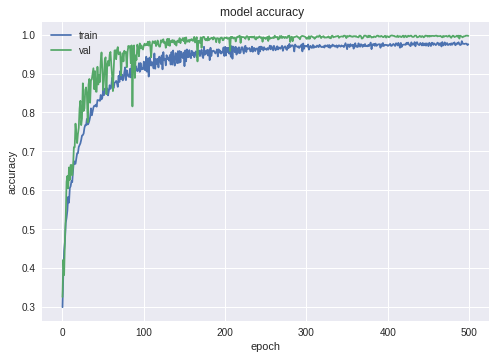

In [0]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'] )
plt.plot(history.history['val_categorical_accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

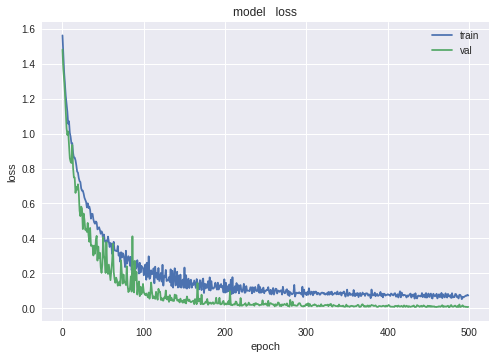

In [0]:
# summarize history for loss
plt.plot(history.history['loss'] )

plt.plot(history.history['val_loss'])
plt.title('model   loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()